In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from comet_ml import Experiment
import os
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.calibration import calibration_curve
import pickle





In [44]:
def metrics(model, x_test, y_test, model_name, features_name):
    '''
    calculate and log the metrics like: accuracy score for validation
    dataset, confusion matrix, ROC AUC score, ROC curve.
    '''
    pred = model.predict(x_test)
    acc_ex = accuracy_score(y_test,pred)
    #experiment.log_metric(f"validation accuracy {model_name}-{features_name}", acc_ex)
    #experiment.log_confusion_matrix(y_test,pred)
    print(f"Validation Accuracy: {acc_ex}")
    prob_predicted = model.predict_proba(x_test)
    lr_probs = prob_predicted[:,1]
    lr_auc = np.round((roc_auc_score(y_test, lr_probs)),4)
    print(f"ROC AUC:{lr_auc}")
    #experiment.log_metric(f"AUC Score {model}- {features_name} ", lr_auc)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    #experiment.log_curve(f"roc-curve-class-{model}-{features_name}",lr_fpr, lr_tpr)
    #experiment.end()


    return acc_ex, lr_auc, lr_fpr, lr_tpr, lr_probs



    

In [45]:
def plot_gr_perc(lr_probs, y_test):
    df_prob_goals = pd.DataFrame()
    df_prob_goals['y_prob_lr'] = lr_probs
    df_prob_goals['y_test'] = y_test

    d = np.sort(df_prob_goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    y = pd.cut(df_prob_goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    y =y.groupby('y_prob_lr', as_index=False).size()
    y.columns = ['y_prob_lr', 'count']

    
    return df_prob_goals, x, y

In [46]:
def plot_partition_perc(df_prob_goals):
    goals = df_prob_goals[df_prob_goals['y_test']==1]

    d = np.sort(goals['y_prob_lr'])
    # Percentile values
    p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])
    perc = np.percentile(d, p)

    x = pd.cut(goals['y_prob_lr'], bins=perc, duplicates = 'drop').reset_index()
    x =x.groupby('y_prob_lr', as_index=False).size()
    x.columns = ['y_prob_lr', 'count']

    z = len(goals['y_test'])

    return x, z

    

In [47]:
df_train = pd.read_csv("train_2015_2018.csv")

In [48]:

#1df_train = df_train[df_train.str.contains==False]
columns_main = ['is_goal','period', 'coordinate_x', 'coordinate_y', 'empty_net','last_coord_x', 'last_coord_y', 'last_period',
       'number_friendly', 'number_opposing',
       'power_play', 'distance', 'from_last_distance', 'angle', 'last_angle',
       'time_from_last', 'change_angle']
columns = ['period', 'coordinate_x', 'coordinate_y', 'empty_net','last_coord_x', 'last_coord_y', 'last_period',
       'number_friendly', 'number_opposing',
       'power_play', 'distance', 'from_last_distance', 'angle', 'last_angle',
       'time_from_last', 'change_angle']

In [49]:
df_train.head()

,Unnamed: 0,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,...,number_friendly,number_opposing,power_play,distance,from_last_distance,angle,last_angle,time_from_last,change_angle,speed
0,0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,6.0,...,5,5,0,34.5254,154.275727,0.1747,1.4248,51,0.0000,0.000000
1,1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-79.0,0.0,...,5,5,0,10.0000,50.477718,0.0000,0.4939,65,0.0000,0.000000
2,2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-75.0,-1.0,...,5,5,0,14.0357,4.123106,0.0713,0.0000,6,0.0713,0.687184
3,3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,-36.0,...,5,5,0,49.5177,79.605276,0.8140,1.5137,53,0.0000,0.000000
4,4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-61.0,-1.0,...,5,5,0,28.0179,22.472205,0.0357,0.8330,37,0.0000,0.000000


In [50]:
le = LabelEncoder()
df_train["shot_type"] = le.fit_transform(df_train["shot_type"])
df_train["last_type"] = le.fit_transform(df_train["last_type"])

In [51]:
df=df_train.replace([np.inf, -np.inf], np.nan, inplace=True)


In [52]:
df = df_train[columns_main].dropna().reset_index(drop=True)


In [53]:
X = df[columns]
y =df['is_goal']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [55]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(262051, 16)
(262051,)
(65513, 16)
(65513,)


In [56]:
os.environ['COMET_API_KEY'] = 'c2REbE8eQaoRTP059ajV8VYn9'


In [57]:
COMET_API_KEY = os.environ.get("COMET_API_KEY")

# Logistic Regression 

In [14]:
pca = PCA()
X_train = StandardScaler().fit_transform(X_train)
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
print(len(explained_variance))
print(sum(explained_variance[0:15]))

16
0.9999999999999999


In [15]:
pca = PCA()


# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipe = Pipeline(steps=[('scaler', StandardScaler()), ("pca", pca), ("logistic", logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "pca__n_components": [7 ,10, 11,13],
    "logistic__C": np.logspace(-4, 4, 4),
}

search_logR = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=10)
search_logR.fit(X_train, y_train)



print("Best parameter (CV score=%0.3f):" % search_logR.best_score_)
print(search_logR.best_params_)



ConfusionMatrixDisplay.from_estimator(search_logR, X_test, y_test,
                                display_labels=['No_Goal','Goal'],
                                cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits


exception calling callback for <Future at 0x14c0aac90 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift67



--------------------------------------------------------------------------------


--------------------------------------------------------------------------------LokyProcess-1 failed with traceback: 
--------------------------------------------------------------------------------

LokyProcess-2 failed with traceback: 
--------------------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 164, in <module>
    prep_data = pickle.load(from_parent)
ValueError: unsupported pickle protocol: 5
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 164, in <module>
    prep_data = pickle.load(from_parent)
ValueError: unsupported pickle 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1)}

In [134]:
acc_ex_lr, lr_auc_lr, lr_fpr_lr, lr_tpr_lr, lr_probs_lr = metrics(search_logR, X_test, y_test, "lr", "Question6")

/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Validation Accuracy: 0.9064148221611144
ROC AUC:0.6949


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


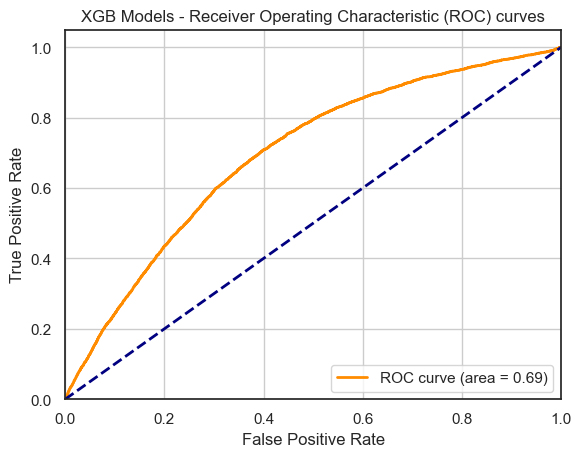

{'web': 'https://www.comet.com/api/asset/download?assetId=37dd26acde4b4c37811d3215d4cb6b43&experimentKey=038c14c5716b4e9291a19371fa2311b2',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=37dd26acde4b4c37811d3215d4cb6b43&experimentKey=038c14c5716b4e9291a19371fa2311b2',
 'assetId': '37dd26acde4b4c37811d3215d4cb6b43'}

In [135]:
#plot roc
from sklearn.metrics import roc_curve, auc

y_score = search_logR.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Models - Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")
plt.grid()



plt.show()
experiment.log_curve(f"ROC - Logistic Regression",fpr, tpr)

In [137]:
df_prob_goals_lr, x_lr, y_lr = plot_gr_perc(lr_probs_lr, y_test)

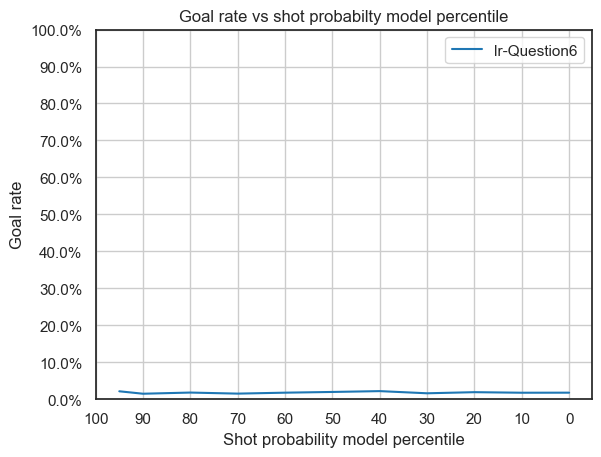

In [138]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_lr['count'] / y_lr['count']), label = 'lr-Question6')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
yticks = mtick.FormatStrFormatter('%.1f%%' )
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [141]:
x_partition_lr, z_lr = plot_partition_perc(df_prob_goals_lr)

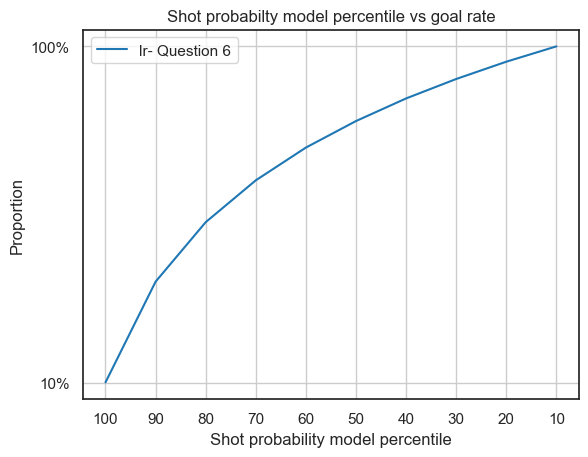

In [142]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_lr['count']/z_lr))).cumsum(), label = 'lr- Question 6')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

In [34]:
# experiment.log_image('Goal Rate of Logistic Regression.png')
# experiment.log_image('Cumulative % of goals.png')

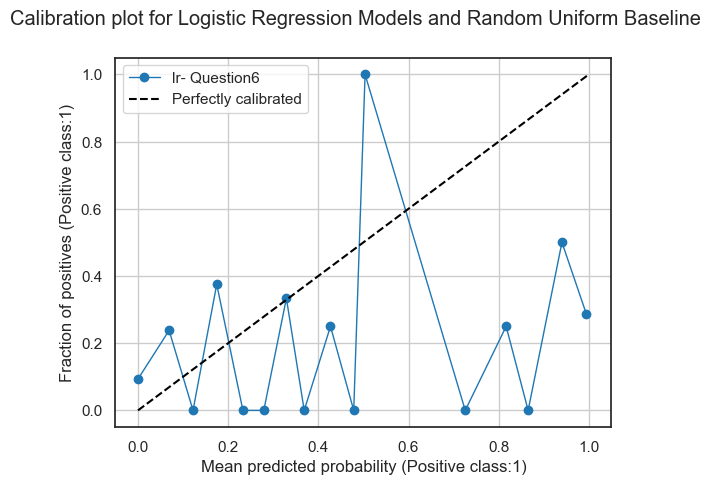

In [144]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs_lr, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='lr- Question6')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pickle.dump(search_logR, open('model_6_lr.pickle', "wb"))


In [ ]:
model_6 = pickle.load(open('model_6_lr.pickle', "rb"))


In [ ]:
#log the best model for 5.2
experiment_best_model6 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_best_model6.set_name('Question-6/LogBestModel6')

experiment_best_model6.log_model('model_6_lr.pickle', 'model_6_lr.pickle', overwrite=True)

experiment_best_model6.end()

# SVC

In [13]:
from sklearn.svm import SVC

0.912109873927482


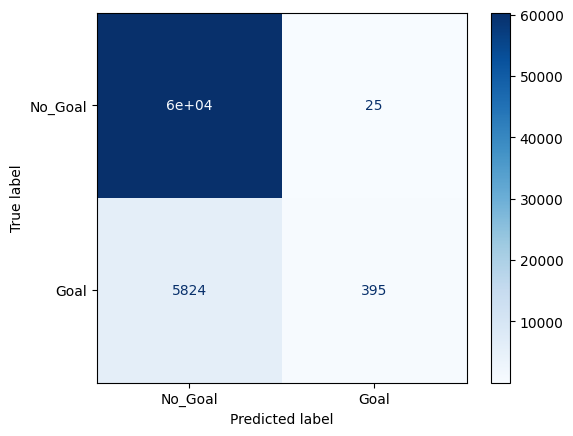

In [14]:
from sklearn.svm import SVC

search_svc = Pipeline(steps=[('scaler', StandardScaler()), ("pca", PCA(n_components = 15)), ("svc", SVC(kernel='rbf',C=10, probability=True))])



X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, stratify=y, test_size=0.10, random_state=0)

search_svc.fit(X_test_svm, y_test_svm)



print(search_svc.score(X_test, y_test))
ConfusionMatrixDisplay.from_estimator(search_svc, X_test, y_test,
                                display_labels=['No_Goal','Goal'],
                                cmap=plt.cm.Blues)
plt.show()

In [ ]:
acc_ex_svc, lr_auc_svc, lr_fpr_svc, lr_tpr_svc, lr_probs_svc = metrics(search_svc, X_test, y_test_svm, "svc", "Question6")

Validation Accuracy: 0.9135687453042824
ROC AUC:0.8456


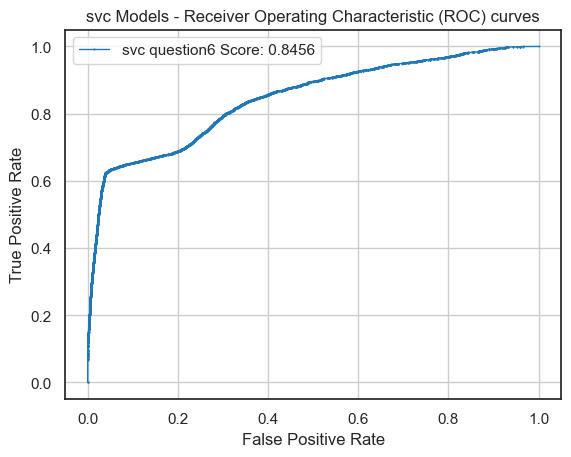

In [ ]:
#ROC PLOT
plt.plot(lr_fpr_svc, lr_tpr_svc, marker='.', linewidth=1, markersize=1,label=f"svc question6 Score: {lr_auc_svc}")
plt.title('svc Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [ ]:
df_prob_goals_svc, x_svc, y_svc = plot_gr_perc(lr_probs_svc, y_test)

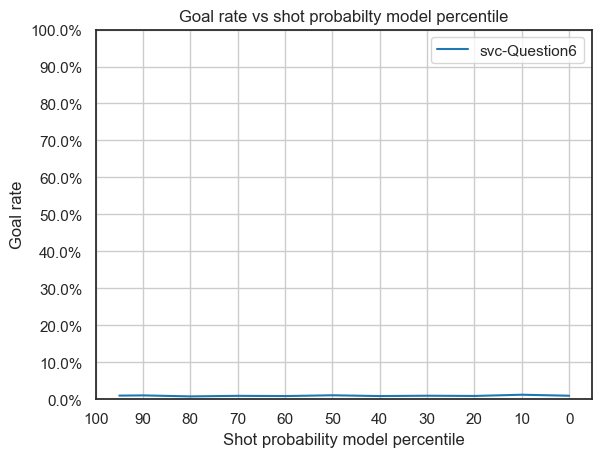

In [ ]:

sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_svc['count'] / y_svc['count']), label = 'svc-Question6')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
yticks = mtick.FormatStrFormatter('%.1f%%' )
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [ ]:
x_partition_svc, z_svc = plot_partition_perc(df_prob_goals_svc)

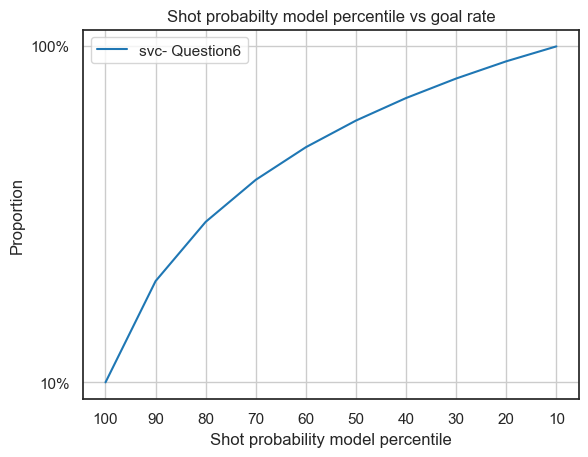

In [ ]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_svc['count']/z_svc))).cumsum(), label = 'svc- Question6')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.grid()
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

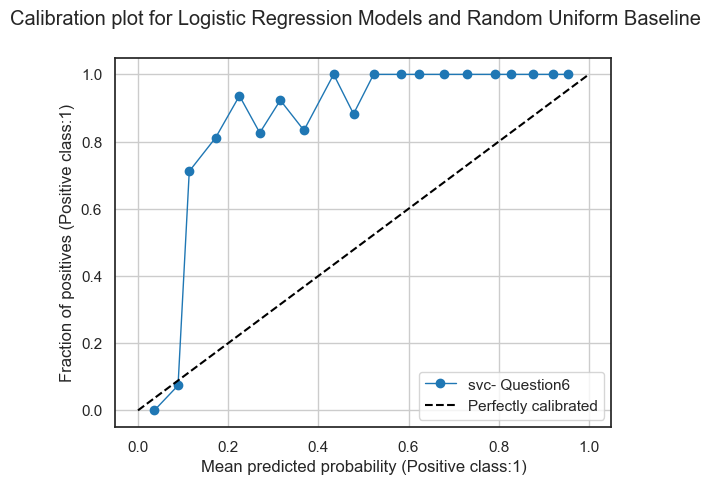

In [ ]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs_svc, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='svc- Question6')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.3943034206951292


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


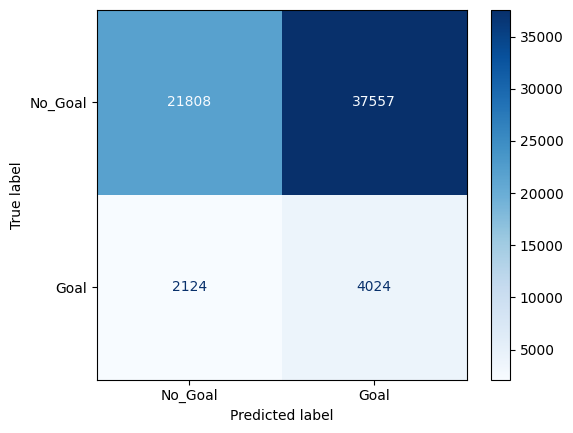

In [17]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators = 200, max_features = 'sqrt', oob_score = True) 

search_rf = Pipeline(steps=[('scaler', StandardScaler()), ("pca", PCA(n_components = 13)), ("rfc",rfc)])


search_rf.fit(X_train, y_train)

print(search_rf.score(X_test, y_test))
ConfusionMatrixDisplay.from_estimator(search_rf, X_test, y_test,
                                display_labels=['No_Goal','Goal'],
                                cmap=plt.cm.Blues)
plt.show()

In [59]:
acc_ex_rf, lr_auc_rf, lr_fpr_rf, lr_tpr_rf, lr_probs_rf = metrics( search_rf, X_test, y_test, "RF", "Question6")

/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Validation Accuracy: 0.3943034206951292


/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ROC AUC:0.5462


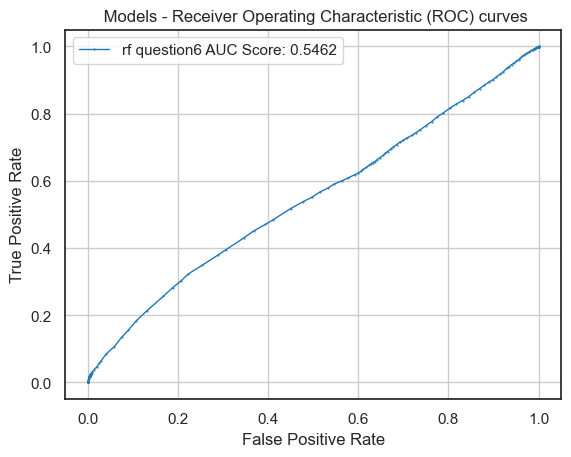

In [60]:
#ROC PLOT
plt.plot(lr_fpr_rf, lr_tpr_rf, marker='.', linewidth=1, markersize=1,label=f"rf question6 AUC Score: {lr_auc_rf}")
plt.title(' Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [61]:
df_prob_goals_rf, x_rf, y_rf = plot_gr_perc(lr_probs_rf, y_test)

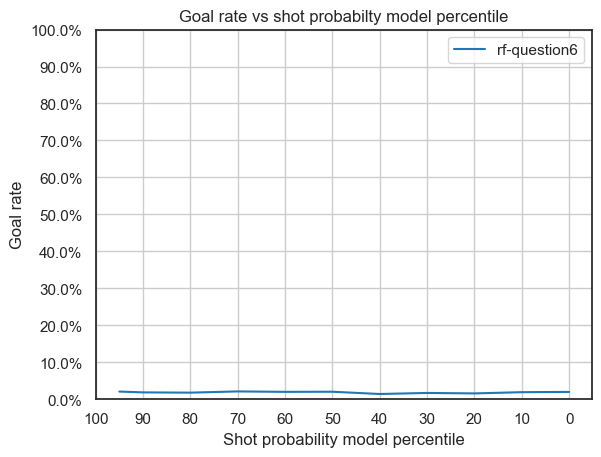

In [62]:

sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_rf['count'] / y_rf['count']), label = 'rf-question6')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
yticks = mtick.FormatStrFormatter('%.1f%%' )
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [30]:
x_partition_rf, z_rf = plot_partition_perc(df_prob_goals_rf)

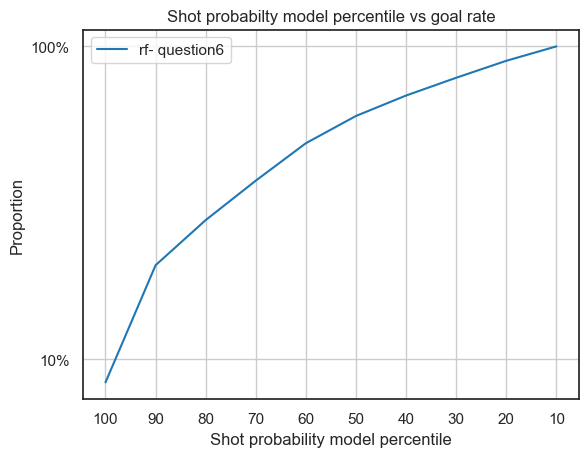

In [31]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_rf['count']/z_rf))).cumsum(), label = 'rf- question6')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

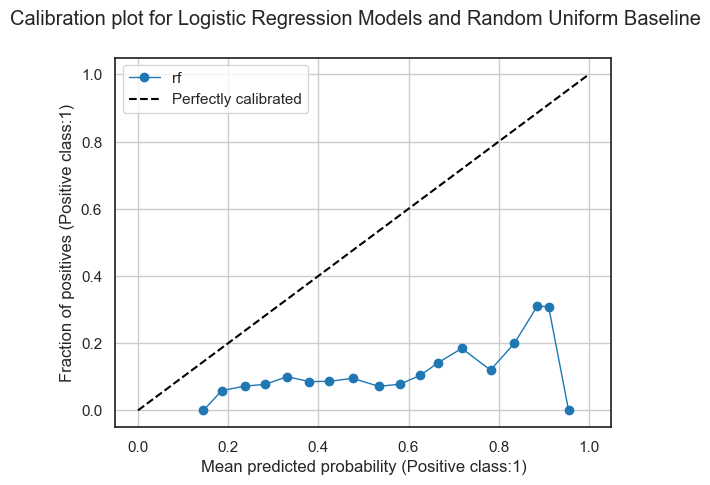

In [34]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs_rf, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [37]:
import pickle
pickle.dump(search_rf, open('model_6_rf.pickle', "wb"))


In [38]:
model_rf = pickle.load(open('model_6_rf.pickle', "rb"))



In [39]:
#log the best model for 5.2
experiment_best_model_6rf = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_best_model_6rf.set_name('Question-6/LogBestModel_rf')

experiment_best_model_6rf.log_model('model_6_rf.pickle', 'model_6_rf.pickle', overwrite=True)

experiment_best_model_6rf.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift-6758-2/ift-6758/e60d58c448b4440ea781d1abea17389a

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/e60d58c448b4440ea781d1abea17389a
COMET INFO:   Others:
COMET INFO:     Name : Question-6/LogBestModel_rf
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename             

# NN

In [63]:
from sklearn.neural_network import MLPClassifier

In [64]:
mlp = MLPClassifier(batch_size=500, activation = 'relu', learning_rate='adaptive', max_iter=200, verbose=True,  early_stopping=True)


pipe = Pipeline(steps=[('scaler', StandardScaler()), ("pca", PCA(n_components = 13)), ("mlp",mlp)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
parameter_space = {
    'mlp__hidden_layer_sizes': [(60,60),(20,20,20),(100,100),(200)],
}


search_mlp = GridSearchCV(pipe, parameter_space, n_jobs=-1, verbose=10)
search_mlp.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search_mlp.best_score_)
print(search_mlp.best_params_)

print("Grid scores on development set:")
print()
means = search_mlp.cv_results_['mean_test_score']
stds = search_mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_mlp.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

ConfusionMatrixDisplay.from_estimator(search_mlp, X_test, y_test,
                                display_labels=['No_Goal','Goal'],
                                cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


exception calling callback for <Future at 0x14f9eb8d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift67



--------------------------------------------------------------------------------
LokyProcess-3 failed with traceback: 
--------------------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 164, in <module>
    prep_data = pickle.load(from_parent)
ValueError: unsupported pickle protocol: 5


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
LokyProcess-7 failed with traceback: 
--------------------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 164, i

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [104]:
acc_ex_nn, lr_auc_nn, lr_fpr_nn, lr_tpr_nn, lr_probs_nn = metrics(search_mlp, X_test, y_test, "mlp", "Question6")

/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/minaparham/Desktop/course/Data science/IFT6758-Project/ift6758-venv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Validation Accuracy: 0.9062645569430045
ROC AUC:0.6525


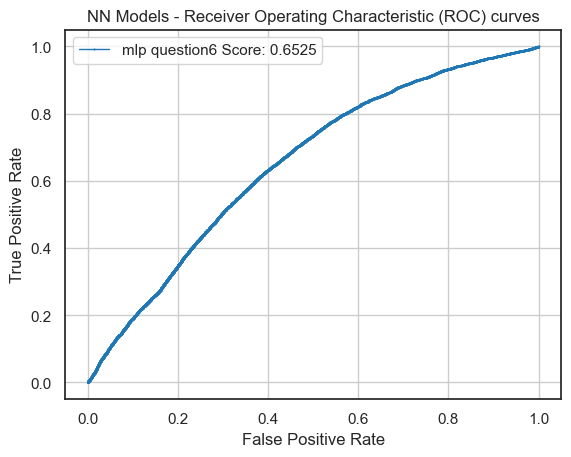

In [105]:
#ROC PLOT
plt.plot(lr_fpr_nn, lr_tpr_nn, marker='.', linewidth=1, markersize=1,label=f"mlp question6 Score: {lr_auc_nn}")
plt.title('NN Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [106]:
df_prob_goals_nn, x_nn, y_nn = plot_gr_perc(lr_probs_nn, y_test)

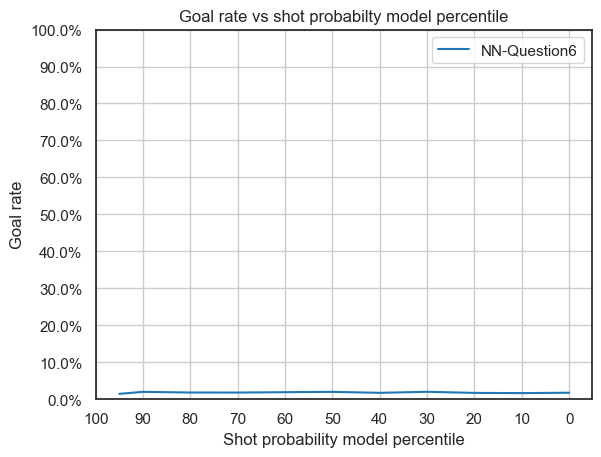

In [107]:

sns.set_theme(style="white", palette=None)
sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x_nn['count'] / y_nn['count']), label = 'NN-Question6')
plt.title('Goal rate vs shot probabilty model percentile')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Goal rate")
yticks = mtick.FormatStrFormatter('%.1f%%' )
plt.gca().yaxis.set_major_formatter(yticks)
plt.gca().invert_xaxis()
plt.grid()
plt.xticks(np.arange(0, 101, 10.0))
plt.yticks(np.arange(0, 101, 10.0))
plt.show()


In [108]:
x_partition_nn, z_nn = plot_partition_perc(df_prob_goals_nn)

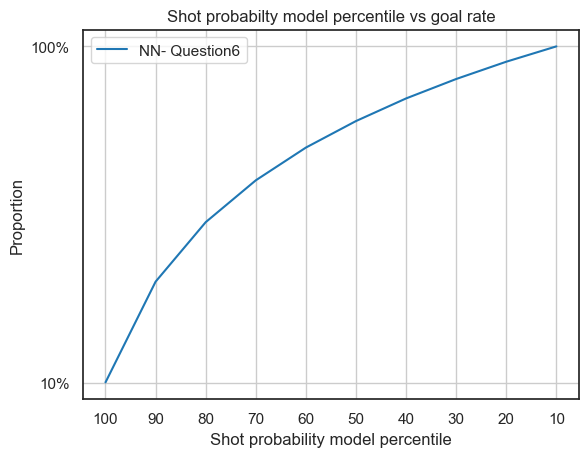

In [109]:
sns.set_theme(style="white", palette=None)
sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100' ]), y = (np.flip((x_partition_nn['count']/z_nn))).cumsum(), label = 'NN- Question6')
plt.title('Shot probabilty model percentile vs goal rate')
plt.xlabel('Shot probability model percentile')
plt.ylabel("Proportion")
plt.grid()
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

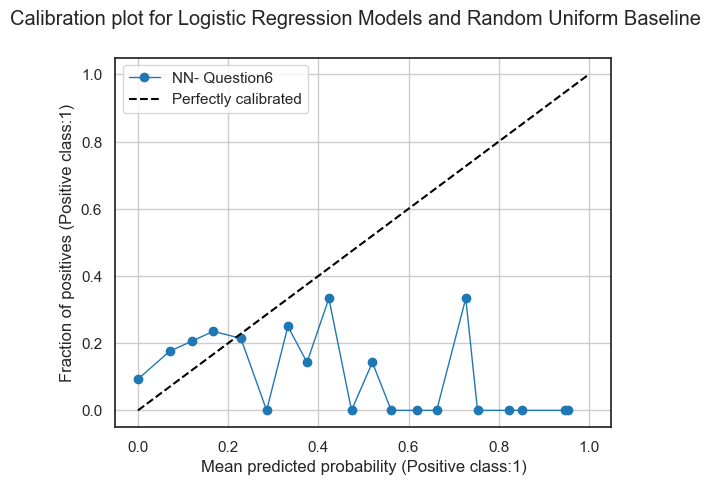

In [110]:
xgb_y, xgb_x = calibration_curve(y_test, lr_probs_nn, n_bins=20)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(xgb_x,xgb_y, marker='o', linewidth=1, label='NN- Question6')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()

In [16]:
import pickle
pickle.dump(search_mlp, open('model_6_mlp.pickle', "wb"))



In [17]:
model_6_mlp = pickle.load(open('model_6_mlp.pickle', "rb"))



In [18]:
#log the best model for 5.2
experiment_best_model6 = Experiment(
    api_key=COMET_API_KEY,
    project_name="ift-6758",
    workspace="ift-6758-2",
)
experiment_best_model6.set_name('Question-6/LogBestModel6')

experiment_best_model6.log_model('model_6_mlp.pickle', 'model_6_mlp.pickle', overwrite=True)

experiment_best_model6.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift-6758-2/ift-6758/dd663ac99e7d4c1aa9a06e2e8913644d
COMET INFO:   Others:
COMET INFO:     Name : Question-6/bestmodel
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (78.74 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: 